# Predicting Demonstration Size on Demographic Characteristics and Salience

## GW DATS 6103: Introduction to Data Mining Final Project
### Name: Alexander D. Silberman

Note: Data is limited to 2017–2018, as that is the publically-available overlap.

In [271]:
# import cuml

# %load_ext cuml.accel

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import re

from census import Census
from us import states

import censusdis.data as ced
from censusdis.datasets import ACS1_PROFILE
from censusdis import states

from statsmodels.formula.api import ols # for linear regression

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_curve, auc

seed = 42

## Data Acquisition and Wrangling

### Results Dataset: Crowd Counting Consortium Phase 1 (2017-2020)

Our results dataset: Crowd Counting Consortium Phase 1 (2017-2020): https://ash.harvard.edu/programs/crowd-counting-consortium/

In [2]:
crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")
crowd_data_orig.head(5)

C:\Users\alexa\AppData\Local\Temp\ipykernel_26424\1640917472.py:1: DtypeWarning: Columns (6,22,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")


,date,locality,state,location_detail,online,type,macroevent,actors,claims,valence,...,source_28,source_29,source_30,notes,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code
0,2017-01-01,Washington,DC,Lafayette Square Park,0.0,vigil,NaN,NaN,"for banning nuclear weapons, for peace",0.0,...,NaN,NaN,NaN,"White House Peace Vigil continuous since June 3, 1981",38.907192,-77.036871,Washington,District of Columbia,DC,11001.0
1,2017-01-01,Mankato,MN,NaN,0.0,vigil,NaN,Peace Vigil Mankato,for peace,0.0,...,NaN,NaN,NaN,every Sunday since 2001,44.163578,-93.999400,Mankato,Blue Earth County,MN,27013.0
2,2017-01-01,Minneapolis,MN,U.S. Bank Stadium,0.0,protest; banner drop,NaN,general protestors,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",1.0,...,NaN,NaN,NaN,hung banner from stadium roof during NFL game,44.977753,-93.265011,Minneapolis,Hennepin County,MN,27053.0
3,2017-01-01,Little Compton,RI,Town Green,0.0,vigil,NaN,Sakonnet Peace Alliance,"for peace, for gun control, for climate action",1.0,...,NaN,NaN,NaN,every Sunday since 2003,41.510103,-71.171156,Little Compton,Newport County,RI,44005.0
4,2017-01-01,Oak Ridge,TN,Y-12 National Security Complex,0.0,vigil,NaN,Oak Ridge Environmental Peace Alliance,for abolishing nuclear weapons,0.0,...,NaN,NaN,NaN,every Sunday since the late 1990s,36.010356,-84.269645,Oak Ridge,Anderson County,TN,47001.0


Keep only data with a crowd size, information about what the crowd gathered for, and a FIPS code, and which aren't online.

In [3]:
crowd_data = crowd_data_orig[(crowd_data_orig["issues"].notna()) & 
                             (crowd_data_orig["size_mean"].notna()) & 
                             (crowd_data_orig["fips_code"].notna()) &
                             (crowd_data_orig["online"] == 0) &
                             (crowd_data_orig["size_mean"] != 0) &
                             (crowd_data_orig["size_mean"].notna()) &
                             (crowd_data_orig["type"].notna())]
crowd_data.drop(columns=np.array(["source_"]*30)+np.arange(1,31).astype(str)).isna().sum()[crowd_data.drop(columns=np.array(["source_"]*30)+np.arange(1,31).astype(str)).isna().sum() > 0]

location_detail       2749
macroevent           32293
actors                1220
valence                 10
size_text             6536
size_high               33
arrests               3927
injuries_crowd        3985
injuries_police       3973
property_damage       3956
chemical_agents      30723
notes                29202
lat                      2
lon                      2
resolved_locality      340
resolved_county       1923
resolved_state          10
dtype: int64

In [4]:
# source_cols = np.array(["source_"]*30) + np.arange(1,31).astype(str)
# crowd_data.drop(columns=source_cols, inplace=True)
# crowd_data.head(5)
# crowd_data["fips_code"] = crowd_data["fips_code"].astype(np.int16)
# crowd_data["fips_code"]

crowd_data["year"] = crowd_data["date"].apply(lambda x:x[:4]).astype(int)
crowd_data["year"]


C:\Users\alexa\AppData\Local\Temp\ipykernel_26424\3801195337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowd_data["year"] = crowd_data["date"].apply(lambda x:x[:4]).astype(int)


2        2017
8        2017
13       2017
14       2017
16       2017
         ... 
72155    2020
72156    2020
72167    2020
72168    2020
72172    2020
Name: year, Length: 33467, dtype: int64

Limit to the years 2017 and 2018

In [5]:
crowd_data = crowd_data[(crowd_data["year"] == 2017) | (crowd_data["year"] == 2018)]

Add column for `log_size_mean`

In [6]:
crowd_data["log_size_mean"] = crowd_data["size_mean"].apply(np.log)
crowd_data["log_size_mean"]

2        0.693147
8        2.890372
13       5.298317
14       5.703782
16       0.693147
           ...   
32405    5.010635
32413    2.484907
32415    2.995732
32424    4.605170
32426    3.401197
Name: log_size_mean, Length: 16703, dtype: float64

In [7]:
print(crowd_data["fips_code"].isna().sum(), "out of", len(crowd_data))

0 out of 16703


0 unresolved localities out of 16764; we need not discard any data and may cast as string.

In [102]:
# crowd_data = crowd_data[crowd_data["fips_code"].notna()]
crowd_data["fips_code"] = crowd_data["fips_code"].astype(int).astype(str).str.rjust(5,"0").astype("category")
crowd_data["fips_code"]

2        27053
8        12086
13       26161
14       38085
16       36061
         ...  
32405    37081
32413    01101
32415    17031
32424    30087
32426    39035
Name: fips_code, Length: 16701, dtype: category
Categories (1316, object): ['01003', '01007', '01015', '01041', ..., '56041', '66000', '72000', '78000']

Reindex to requisite columns

In [9]:
crowd_data = crowd_data[["year","fips_code","type","issues","claims","size_mean", "log_size_mean", "size_cat"]]
crowd_data

,year,fips_code,type,issues,claims,size_mean,log_size_mean,size_cat
2,2017,27053,protest; banner drop,banking and finance; economy; energy; environment; indigenous peoples,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",2.0,0.693147,1
8,2017,12086,demonstration,policing,"in remembrance of Jamal Rollins, against police brutality, for police transparency",18.0,2.890372,1
13,2017,26161,protest,education; racism,"against racial incidents on campus, for pressuring university administration to do something, against racism",200.0,5.298317,2
14,2017,38085,protest; occupying land,energy; environment,"for environmental rights, against Dakota Access Pipeline",300.0,5.703782,2
16,2017,36061,protest,presidency,against Trump's campaign and upcoming presidency,2.0,0.693147,1
...,...,...,...,...,...,...,...,...
32405,2018,37081,protest,foreign affairs,in solidarity with the people of Sudan; against current Sudanese leader,150.0,5.010635,2
32413,2018,01101,protest,policing; racism,protesting the shooting death of a black man by police,12.0,2.484907,1
32415,2018,17031,protest,housing,protesting against the demolition of a historic home and apartment complex,20.0,2.995732,1
32424,2018,30087,protest,women's rights,protesting to bring awareness to violence against native women,100.0,4.605170,2


Correct mislabeled `type`s

In [10]:
crowd_data_type = crowd_data["type"].str.lower()#.str.replace(r"\s+", " ", regex=True)

crowd_data_type_repl_dict = {"nat'l":"national",
                             ",":";", "/":";", " and ":";", "'":";", ":":";",
                             "block highways":"block highway",
                             "counter-protest":"counterprotest",
                             "demonstraton":"demonstration", "demonstation":"demonstration", "demonstrations":"demonstration", "demonstarion":"demonstration", 
                             "demonstratin":"demonstration", "deomnstration":"demonstration", "demonstartion":"demonstration",
                             "flashmob":"flash mob",
                             "marach":"march",
                             "protests":"protest", "protestors":"protest", "protesst":"protest", "protest0":"protest",
                             "raly":"rally", "rallies":"rally",
                             "sit-in demonstration":"sit-in",
                             "walk in":"walk-in","walkin":"walk-in",
                             "walk out":"walk-out", "walkout":"walk-out","walkut":"walk-out"
                             }

for key, value in crowd_data_type_repl_dict.items():
    crowd_data_type = crowd_data_type.str.replace(key, value)
    
crowd_data_type = crowd_data_type.str.split(";").explode().astype(str).str.lstrip().str.rstrip()
crowd_data_type = crowd_data_type.loc[(crowd_data_type != "nan") & (crowd_data_type != "m") & (crowd_data_type != "0.0")]
crowd_data_type.unique()

array(['protest', 'banner drop', 'demonstration', 'occupying land',
       'strike', 'vigil', 'rally', 'direct action', 'march',
       'flag burning', 'block highway', 'sign held on crane',
       'counterprotest', 'sit-in', 'standoff', 'dance', 'blockade',
       'nonviolent blockade', 'road blockade', 'mass mooning',
       'kindness march', 'civil disobedience', 'walk-out',
       'human barricade', 'block streets', 'peace march',
       'protest (armed)', 'hunger strike', 'sick out', 'boycott',
       'swim protest', 'die-in', 'boycott classes', 'resignation',
       'turn backs to speaker', 'protest resignation', 'die in',
       'art projection', 'sing-in', 'skits', 'flash mob', 'flotilla',
       'counter protest', 'block interactions', 'light rail stop',
       'superhero rally', 'aircraft flyover', 'death train',
       'street blockade', 'encampment', '"drive"', 'railroad blockade',
       'pray-in', 'picket', 'railway blockade', 'protest hike',
       'festival', 'protest (

Onehot encode `type`

In [ ]:
type_onehot = pd.get_dummies(crowd_data_type, prefix="type").groupby(crowd_data_type.index).any()
# type_onehot

crowd_data = crowd_data.drop(columns="type").join(type_onehot)
crowd_data = crowd_data[crowd_data.notna().all(axis=1)]
crowd_data

,year,fips_code,issues,claims,size_mean,log_size_mean,size_cat,"type_""drive""","type_""kookout""",type_aircraft flyover,...,type_strike,type_superhero rally,type_support walk-out,type_swim protest,type_teach in,type_turn backs to speaker,type_vigil,type_walk,type_walk-in,type_walk-out
2,2017,27053,banking and finance; economy; energy; environment; indigenous peoples,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",2.0,0.693147,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,2017,12086,policing,"in remembrance of Jamal Rollins, against police brutality, for police transparency",18.0,2.890372,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,2017,26161,education; racism,"against racial incidents on campus, for pressuring university administration to do something, against racism",200.0,5.298317,2,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,2017,38085,energy; environment,"for environmental rights, against Dakota Access Pipeline",300.0,5.703782,2,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16,2017,36061,presidency,against Trump's campaign and upcoming presidency,2.0,0.693147,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32405,2018,37081,foreign affairs,in solidarity with the people of Sudan; against current Sudanese leader,150.0,5.010635,2,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32413,2018,01101,policing; racism,protesting the shooting death of a black man by police,12.0,2.484907,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32415,2018,17031,housing,protesting against the demolition of a historic home and apartment complex,20.0,2.995732,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32424,2018,30087,women's rights,protesting to bring awareness to violence against native women,100.0,4.605170,2,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Type `size_cat` as category and `size_mean` as int

In [12]:
crowd_data["size_cat"] = crowd_data["size_cat"].astype("category").cat.as_ordered()
crowd_data["size_mean"] = crowd_data["size_mean"].astype(int)
crowd_data[["size_cat","size_mean"]]

,size_cat,size_mean
2,1,2
8,1,18
13,2,200
14,2,300
16,1,2
...,...,...
32405,2,150
32413,1,12
32415,1,20
32424,2,100


Prepare `issues` for merging

In [13]:
crowd_data_problems = pd.concat([crowd_data["issues"].str.split("; "),crowd_data["year"]],axis=1)
crowd_data_problems

,issues,year
2,"[banking and finance, economy, energy, environment, indigenous peoples]",2017
8,[policing],2017
13,"[education, racism]",2017
14,"[energy, environment]",2017
16,[presidency],2017
...,...,...
32405,[foreign affairs],2018
32413,"[policing, racism]",2018
32415,[housing],2018
32424,[women's rights],2018


### American Community Survey

In [14]:
api_key = "29e7dfea2f8b253a0a10ccd9626f78e49f4f0a4f"

def regex_filter(string, myregex):
    if string:
        mo = re.search(myregex, string)
        if mo:
            return True
        else:
            return False
    else:
        return False

census_vars_orig = ced.variables.search(ACS1_PROFILE, 2017)
census_vars = census_vars_orig[(census_vars_orig["GROUP"] != "N/A")]
census_vars_pcts = census_vars[census_vars["VARIABLE"].apply(regex_filter,myregex=r"PE$")]
census_vars_pcts_no_ratio = census_vars_pcts[~census_vars_pcts["LABEL"].apply(regex_filter,myregex=r"Sex\sratio")]

census_vars_agg = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"(Median)|(Mean)|(Average)|(Per\s)|(\srate)")]
# census_vars_tot = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"Total(?!.*\!\!)")]
# census_vars_tot[["VARIABLE","LABEL"]]

census_vars_agg[["VARIABLE","LABEL"]]

census_vars_pcts_no_ratio_agg = census_vars_pcts_no_ratio.drop(census_vars_agg.index)

census_vars_agg_ests = census_vars_agg["VARIABLE"].apply(lambda x:x.replace("PE","E"))

In [15]:
census_vars_to_drop = ["DP05_0033PE", # same as DP05_0001PE (Total Population)
                       "DP05_0105PE", # total housing units—replace with DP05_0105E, which is the same as DP04_0001PE
                       "DP04_0006PE", # same as DP04_0001PE	
                       "DP04_0016PE", # same as DP04_0001PE	
                       "DP04_0027PE", # same as DP04_0001PE	
                       "DP04_0038PE" # same as DP04_0001PE	
                       ]

census_vars_to_add = []

census_vars_pcts_no_ratio_agg_drop = census_vars_pcts_no_ratio_agg["VARIABLE"][~census_vars_pcts_no_ratio_agg["VARIABLE"].isin(census_vars_to_drop)]

census_vars_final = pd.concat([pd.Series(["NAME"]), 
                               pd.concat([census_vars_pcts_no_ratio_agg_drop, 
                                          census_vars_agg_ests, 
                                          pd.Series(census_vars_to_add)], 
                                         ignore_index=True).sort_values()], 
                              ignore_index=True)

census_vars_final

0               NAME
1      DP02PR_0001PE
2      DP02PR_0002PE
3      DP02PR_0003PE
4      DP02PR_0004PE
           ...      
661      DP05_0085PE
662      DP05_0086PE
663      DP05_0087PE
664      DP05_0088PE
665      DP05_0089PE
Length: 666, dtype: object

Solely request percents. The list of variables includes what should be the total population as a percent—`DP05_0001PE`—but, as that would always be 100%, the wise people at the US Census Bureau made such equal to `DP05_0001E`, the total population estimate, necessitating no further adjustment.

In [16]:
ced.variables.group_tree(ACS1_PROFILE, 2017,"DP02")

+ Estimate
    + HOUSEHOLDS BY TYPE
        + Total households (DP02_0001E)
            + Family households (families) (DP02_0002E)
                + With own children of the householder under 18 years (DP02_0003E)
                + Married-couple family (DP02_0004E)
                    + With own children of the householder under 18 years (DP02_0005E)
                + Male householder, no wife present, family (DP02_0006E)
                    + With own children of the householder under 18 years (DP02_0007E)
                + Female householder, no husband present, family (DP02_0008E)
                    + With own children of the householder under 18 years (DP02_0009E)
            + Nonfamily households (DP02_0010E)
                + Householder living alone (DP02_0011E)
                    + 65 years and over (DP02_0012E)
        + Households with one or more people under 18 years (DP02_0013E)
        + Households with one or more people 65 years and over (DP02_0014E)
        + Aver

In [17]:
census_data = [ced.download(ACS1_PROFILE, year, census_vars_final, 
                           metropolitan_statistical_area_micropolitan_statistical_area ="*", 
                           api_key=api_key
                           ).set_index("METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA")
               for year in range(2017,2019)]


census_data = pd.concat(census_data, keys = np.arange(2017,2019), names=["year"])
census_data

NAME  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                                         
2017 44220                                                                  Springfield, OH Metro Area   
     44300                                                                State College, PA Metro Area   
     44340                                                                   Statesboro, GA Micro Area   
     44420                                                          Staunton-Waynesboro, VA Metro Area   
     44620                                                                Stevens Point, WI Micro Area   
...                                                                                                ...   
2018 31820                                                                    Manitowoc, WI Micro Area   
     31860                                                        Mankato-North Mankato, MN Metro Area   
     31900                                                                    Mansfield, OH Metro Area   
     31940                                                                 Marinette, WI-MI Micro Area   
     31980                                                                       Marion, IN Micro Area   

                                                                  DP02PR_0001PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                                  NaN   
...                                                                         ...   
2018 31820                                                                  NaN   
     31860                                                                  NaN   
     31900                                                                  NaN   
     31940                                                                  NaN   
     31980                                                                  NaN   

                                                                  DP02PR_0002PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                                  NaN   
...                                                                         ...   
2018 31820                                                                  NaN   
     31860                                                                  NaN   
     31900                                                                  NaN   
     31940                                                                  NaN   
     31980                                                                  NaN   

                                                                  DP02PR_0003PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                   

In [18]:
census_data = census_data.drop(columns=census_data.columns[census_data.isna().sum() == len(census_data)])

In [19]:
# metro_micro_area_text = re.compile(r"(\s(Metro|Micro)\sArea)$")
# census_data["NAME"].apply(lambda x: metro_micro_area_text.sub("",x))
# # re.sub(string="New York Metro Area", pattern=r"(Metro|Micro)\sArea$", repl="hello")

### Most Important Problem Dataset, Second Release (2024)

The aggregated data may be found here: https://williamslaro.github.io/talks/dataset2. Previously, the individual data was used, necessitating much preprocessing.

In [20]:
issue_data = pd.read_csv("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\MIPD-2024-Aggregate\\MIPDV2-All-year.csv",encoding="ANSI",
                         index_col=["year","problem"])
issue_data.head(20)

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
1939 1          1           3            8989  45.401001  MIPD (General)   
     2          1           3            8989   6.861000  MIPD (General)   
     3          1           3            8989   0.200000  MIPD (General)   
     4          1           3            8989   0.554000  MIPD (General)   
     5          1           3            8989   4.629000  MIPD (General)   
     6          1           3            8989  33.779999  MIPD (General)   
     7          1           3            8989   0.056000  MIPD (General)   
     8          1           3            8989   0.044000  MIPD (General)   
     9          1           3            8989   1.432000  MIPD (General)   
     10         1           3            8989   4.123000  MIPD (General)   
     11         1           3            8989   0.700000  MIPD (General)   
     12         1           3            8989   0.168000  MIPD (General)   
     13         1           3            8989   1.461000  MIPD (General)   
     14         1           3            8989   0.078000  MIPD (General)   
     15         1           3            8989   0.512000  MIPD (General)   
1940 1          1           1            2907  24.200001  MIPD (General)   
     2          1           1            2907   3.474000  MIPD (General)   
     3          1           1            2907   0.069000  MIPD (General)   
     4          1           1            2907   0.172000  MIPD (General)   
     5          1           1            2907  13.152000  MIPD (General)   

                                             catdesc  \
year problem                                           
1939 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12       general problem categories in the MIPD   
     13       general problem categories in the MIPD   
     14       general problem categories in the MIPD   
     15       general problem categories in the MIPD   
1940 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   

                                   problemname  \
year problem                                     
1939 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
1940 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   

       

Limit to relevant years

In [21]:
issue_data = issue_data.loc[[2017,2018]]
issue_data

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
2017 1          1           2            1999  19.669001  MIPD (General)   
     2          1           2            1999  16.531000  MIPD (General)   
     3          1           2            1999   4.969000  MIPD (General)   
     4          1           2            1999   1.275000  MIPD (General)   
     5          1           2            1999  15.047000  MIPD (General)   
     6          1           2            1999  11.080000  MIPD (General)   
     7          1           2            1999   0.222000  MIPD (General)   
     8          1           2            1999   2.157000  MIPD (General)   
     9          1           2            1999   5.814000  MIPD (General)   
     10         1           2            1999  14.678000  MIPD (General)   
     11         1           2            1999   0.426000  MIPD (General)   
     12         1           2            1999   0.000000  MIPD (General)   
     13         1           2            1999   3.186000  MIPD (General)   
     14         1           2            1999   0.269000  MIPD (General)   
     15         1           2            1999   4.676000  MIPD (General)   
2018 1          1           2            1983  14.319000  MIPD (General)   
     2          1           2            1983  11.224000  MIPD (General)   
     3          1           2            1983   8.407000  MIPD (General)   
     4          1           2            1983   3.457000  MIPD (General)   
     5          1           2            1983  15.009000  MIPD (General)   
     6          1           2            1983  12.685000  MIPD (General)   
     7          1           2            1983   0.282000  MIPD (General)   
     8          1           2            1983   1.959000  MIPD (General)   
     9          1           2            1983   5.000000  MIPD (General)   
     10         1           2            1983  17.754000  MIPD (General)   
     11         1           2            1983   0.707000  MIPD (General)   
     12         1           2            1983   0.000000  MIPD (General)   
     13         1           2            1983   4.345000  MIPD (General)   
     14         1           2            1983   0.125000  MIPD (General)   
     15         1           2            1983   4.728000  MIPD (General)   

                                             catdesc  \
year problem                                           
2017 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12       general problem categories in the MIPD   
     13       general problem categories in the MIPD   
     14       general problem categories in the MIPD   
     15       general problem categories in the MIPD   
2018 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12      

Limit to relevant columns

In [22]:
issue_data_problems = issue_data[["problemname","problemdesc","problemissues","problemexamples","perc"]]
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

Set`problemname` as a categorical variable

In [23]:
issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")
issue_data_problems["problemname"]

C:\Users\alexa\AppData\Local\Temp\ipykernel_26424\1646687161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")


year  problem
2017  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             Fiscal Policy
      6                            Foreign Policy
      7          International Economic Relations
      8                               Environment
      9                                  Morality
      10                                 Politics
      11                             Youth Issues
      12                                   Groups
      13                            Other and All
      14                                      NaN
      15                       Don't Know/Refused
2018  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             

### Merge the Datasets

#### Merge Crowd and Issue Data

Some crowds are gathered for issues that fit into multiple categories, organized in alphabetical order. If this is the case, how should they be merged?

In [24]:
crowd_data["issues"]

2        banking and finance; economy; energy; environment; indigenous peoples
8                                                                     policing
13                                                           education; racism
14                                                         energy; environment
16                                                                  presidency
                                         ...                                  
32405                                                          foreign affairs
32413                                                         policing; racism
32415                                                                  housing
32424                                                           women's rights
32426                                                         criminal justice
Name: issues, Length: 16701, dtype: object

Perhaps solely the issue with the highest salience should be accounted for? Or, perhaps, the pcts should be added, representing the salience of anyone interested in at least one of the issues?

"The percentages can therefore be interpreted as the percentage of the electorate who answered the question and selected that category." -MIPDV2-Codebook p. 5

The latter will be used.

In [25]:
crowd_data_problems = crowd_data_problems.explode(column="issues")
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption', 'covid'],
      dtype=object)

All the issues in the CCC data. Each is to be mapped to a problem code in the MIPD data. This will be done by hand.

But why is `covid` there? This should be limited to the years 2017 and 18.

In [26]:
crowd_data[crowd_data["issues"].str.contains("covid")].reindex(columns=["issues","claims"])

,issues,claims
8278,covid; judiciary,Rally against court's decesion to reopen Rocky Flats
23918,covid; healthcare,Protesting CDC definition of lyme disease
26845,covid; immigration,against ICE; against reopening immigrant detention facility
26968,covid; energy,protesting reopening of Japanese nuclear power plants


According to the data dictionary, "These are generated after data compilation by running a series of regular expressions over the claims description text" (p. 3). These claims all include the words "reopen", "reopening", or "CDC"; these are false positives. As such, `covid` will manually be removed from these four so as to not impact findings.

In [27]:
crowd_data_problems = crowd_data_problems[crowd_data_problems["issues"] != "covid"]

Check again for unique issues:

In [28]:
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption'], dtype=object)

In [29]:
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

In [30]:
issue_code_dict = {'animal rights':14, 
                   'banking and finance':1, 
                   'civil rights':3,
                   'corruption':10, 
                   'criminal justice':3, 
                   'democracy':10,
                   'development':1, 
                   'disability rights':3, 
                   'drugs':4, 
                   'economy':1,
                   'education':2, 
                   'energy':8, 
                   'environment':8, 
                   'foreign affairs':6,
                   'free speech':3, 
                   'guns':4, 
                   'healthcare':2, 
                   'housing':2, 
                   'immigration':5,
                   'indigenous peoples':12, 
                   'judiciary':10, 
                   'labor':1, 
                   'legislative':10,
                   'lgbtqia':3, 
                   'military':6, 
                   'patriotism':9, 
                   'policing':3,
                   'presidency':10,
                   'racism':3, 
                   'religion':9, 
                   'reproductive rights':3, 
                   'science':10,
                   'sexual violence':4, 
                   'sports':13, 
                   'taxes':1, 
                   'transportation':2,
                   "women's rights":3
}

In [31]:
crowd_data_problems["issues"] = crowd_data_problems["issues"].apply(np.vectorize(lambda x:issue_code_dict[x]))
crowd_data_problems_to_merge = crowd_data_problems.reset_index().drop_duplicates() # neccessary to ensure lines with different indexes aren't deleted
crowd_data_problems_to_merge
# crowd_data_problems["problems"]
# crowd_census_data_exploded = crowd_census_data.explode(column="problems")
# crowd_census_data_exploded.head()

# crowd_census_data_issues_exploded = crowd_census_data["issues"].explode()
# problems_onehot = pd.get_dummies(crowd_census_data_problems_exploded).groupby(crowd_census_data_problems_exploded.index).any()
# problems_onehot

,index,issues,year
0,2,1,2017
2,2,8,2017
4,2,12,2017
5,8,3,2017
6,13,2,2017
...,...,...,...
25901,32405,6,2018
25902,32413,3,2018
25904,32415,2,2018
25905,32424,3,2018


Now, this may be merged with the issue data.

We want to keep the index, however, so that we may group by it later.

In [32]:
crowd_problems_data_exploded = crowd_data_problems_to_merge.merge(issue_data_problems[["perc","problemname"]], how="inner", left_on=["year","issues"], right_on=["year","problem"])
crowd_problems_data_exploded

,index,issues,year,perc,problemname
0,2,1,2017,19.669001,Economy
1,2,8,2017,2.157000,Environment
2,2,12,2017,0.000000,Groups
3,8,3,2017,4.969000,Rights
4,13,2,2017,16.531000,Social Policy
...,...,...,...,...,...
24848,32405,6,2018,12.685000,Foreign Policy
24849,32413,3,2018,8.407000,Rights
24850,32415,2,2018,11.224000,Social Policy
24851,32424,3,2018,8.407000,Rights


In [168]:
problems_onehot_to_group = pd.get_dummies(crowd_problems_data_exploded[["index","problemname","perc"]],columns=["problemname"])

problems_onehot_cols = np.setdiff1d(problems_onehot_to_group.columns,["perc","index"])
problems_onehot_grouped = problems_onehot_to_group.groupby(by="index").agg({"perc":"sum"} | dict(zip(problems_onehot_cols,["any"]*len(problems_onehot_cols))))
problems_onehot_grouped

# crowd_problems_perc = crowd_data.drop(columns="type").join(type_onehot)
# crowd_problems_perc

,perc,problemname_Don't Know/Refused,problemname_Economy,problemname_Environment,problemname_Fiscal Policy,problemname_Foreign Policy,problemname_Groups,problemname_International Economic Relations,problemname_Morality,problemname_Other and All,problemname_Politics,problemname_Public Safety,problemname_Rights,problemname_Social Policy,problemname_Youth Issues
index,,,,,,,,,,,,,,,
2,21.826001,False,True,True,False,False,True,False,False,False,False,False,False,False,False
8,4.969000,False,False,False,False,False,False,False,False,False,False,False,True,False,False
13,21.500000,False,False,False,False,False,False,False,False,False,False,False,True,True,False
14,2.157000,False,False,True,False,False,False,False,False,False,False,False,False,False,False
16,14.678000,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32405,12.685000,False,False,False,False,True,False,False,False,False,False,False,False,False,False
32413,8.407000,False,False,False,False,False,False,False,False,False,False,False,True,False,False
32415,11.224000,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [34]:
# crowd_problems_data_exploded_to_group = crowd_problems_data_exploded[["index","problemname","perc"]]
# # crowd_problems_data_exploded_to_group
# crowd_problems_perc = crowd_problems_data_exploded_to_group.groupby(by="index").agg({"perc":sum,"problemname":list})
# crowd_problems_perc

Lastly, merge back with original data.

In [35]:
crowd_problems_data = crowd_data.merge(problems_onehot_grouped, how="inner", left_index=True, right_index=True)
crowd_problems_data

,year,fips_code,issues,claims,size_mean,log_size_mean,size_cat,"type_""drive""","type_""kookout""",type_aircraft flyover,...,problemname_Foreign Policy,problemname_Groups,problemname_International Economic Relations,problemname_Morality,problemname_Other and All,problemname_Politics,problemname_Public Safety,problemname_Rights,problemname_Social Policy,problemname_Youth Issues
2,2017,27053,banking and finance; economy; energy; environment; indigenous peoples,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",2,0.693147,1,False,False,False,...,False,True,False,False,False,False,False,False,False,False
8,2017,12086,policing,"in remembrance of Jamal Rollins, against police brutality, for police transparency",18,2.890372,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
13,2017,26161,education; racism,"against racial incidents on campus, for pressuring university administration to do something, against racism",200,5.298317,2,False,False,False,...,False,False,False,False,False,False,False,True,True,False
14,2017,38085,energy; environment,"for environmental rights, against Dakota Access Pipeline",300,5.703782,2,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16,2017,36061,presidency,against Trump's campaign and upcoming presidency,2,0.693147,1,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32405,2018,37081,foreign affairs,in solidarity with the people of Sudan; against current Sudanese leader,150,5.010635,2,False,False,False,...,True,False,False,False,False,False,False,False,False,False
32413,2018,01101,policing; racism,protesting the shooting death of a black man by police,12,2.484907,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32415,2018,17031,housing,protesting against the demolition of a historic home and apartment complex,20,2.995732,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
32424,2018,30087,women's rights,protesting to bring awareness to violence against native women,100,4.605170,2,False,False,False,...,False,False,False,False,False,False,False,True,False,False


#### Merge with Census Data

In [36]:
cbsa_fips_crosswalk = pd.read_excel("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\list1_2023.xlsx",skiprows=2,dtype=str)
cbsa_fips_crosswalk.head()

,CBSA Code,Metropolitan Division Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Metropolitan Division Title,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,Central/Outlying County
0,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Brown County,South Dakota,46,013,Central
1,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Edmunds County,South Dakota,46,045,Outlying
2,10140,NaN,NaN,"Aberdeen, WA",Micropolitan Statistical Area,NaN,NaN,Grays Harbor County,Washington,53,027,Central
3,10180,NaN,101,"Abilene, TX",Metropolitan Statistical Area,NaN,"Abilene-Sweetwater, TX",Callahan County,Texas,48,059,Outlying
4,10180,NaN,101,"Abilene, TX",Metropolitan Statistical Area,NaN,"Abilene-Sweetwater, TX",Jones County,Texas,48,253,Outlying


In [ ]:
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS State Code"] + cbsa_fips_crosswalk["FIPS County Code"]
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")

Set all variables as categoricals.

In [112]:
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")
cbsa_fips_crosswalk["CBSA Code"] = cbsa_fips_crosswalk["CBSA Code"].astype("category")
cbsa_fips_crosswalk["FIPS State Code"] = cbsa_fips_crosswalk["FIPS State Code"].astype("category")

Drop NaN FIPS codes in preparation for merging.

In [113]:
cbsa_fips_crosswalk = cbsa_fips_crosswalk[cbsa_fips_crosswalk["FIPS Code"].notna()]
cbsa_fips_crosswalk["FIPS Code"]

0       46013
1       46045
2       53027
3       48059
4       48253
        ...  
1910    06101
1911    06115
1912    04027
1913    39119
1914    48505
Name: FIPS Code, Length: 1915, dtype: category
Categories (1915, object): ['01001', '01003', '01005', '01007', ..., '72145', '72149', '72151', '72153']

In [114]:
crowd_problems_cbsa_data = crowd_problems_data.merge(cbsa_fips_crosswalk[["FIPS Code", "CBSA Code", "FIPS State Code"]], 
                                                     how="inner", left_on="fips_code", right_on="FIPS Code").drop(columns="FIPS Code")
crowd_problems_cbsa_data

,year,fips_code,issues,claims,size_mean,log_size_mean,size_cat,"type_""drive""","type_""kookout""",type_aircraft flyover,...,problemname_International Economic Relations,problemname_Morality,problemname_Other and All,problemname_Politics,problemname_Public Safety,problemname_Rights,problemname_Social Policy,problemname_Youth Issues,CBSA Code,FIPS State Code
0,2017,27053,banking and finance; economy; energy; environment; indigenous peoples,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",2,0.693147,1,False,False,False,...,False,False,False,False,False,False,False,False,33460,27
1,2017,12086,policing,"in remembrance of Jamal Rollins, against police brutality, for police transparency",18,2.890372,1,False,False,False,...,False,False,False,False,False,True,False,False,33100,12
2,2017,26161,education; racism,"against racial incidents on campus, for pressuring university administration to do something, against racism",200,5.298317,2,False,False,False,...,False,False,False,False,False,True,True,False,11460,26
3,2017,36061,presidency,against Trump's campaign and upcoming presidency,2,0.693147,1,False,False,False,...,False,False,False,True,False,False,False,False,35620,36
4,2017,11001,presidency,against the certification of president-elect Trump,3,1.098612,1,False,False,False,...,False,False,False,True,False,False,False,False,47900,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15831,2018,37135,education; racism,protesting against a confederate monument on the campus,2,0.693147,1,False,False,False,...,False,False,False,False,False,True,True,False,20500,37
15832,2018,37081,foreign affairs,in solidarity with the people of Sudan; against current Sudanese leader,150,5.010635,2,False,False,False,...,False,False,False,False,False,False,False,False,24660,37
15833,2018,01101,policing; racism,protesting the shooting death of a black man by police,12,2.484907,1,False,False,False,...,False,False,False,False,False,True,False,False,33860,01
15834,2018,17031,housing,protesting against the demolition of a historic home and apartment complex,20,2.995732,1,False,False,False,...,False,False,False,False,False,False,True,False,16980,17


In [115]:
demo_data = crowd_problems_cbsa_data.merge(census_data, how="inner", 
                                           left_on = ["year","CBSA Code"], right_on = ["year","METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA"])
demo_data

,year,fips_code,issues,claims,size_mean,log_size_mean,size_cat,"type_""drive""","type_""kookout""",type_aircraft flyover,...,DP05_0079PE,DP05_0080PE,DP05_0081PE,DP05_0082PE,DP05_0083PE,DP05_0084PE,DP05_0085PE,DP05_0087PE,DP05_0088PE,DP05_0089PE
0,2017,27053,banking and finance; economy; energy; environment; indigenous peoples,"against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline",2,0.693147,1,False,False,False,...,0.5,6.7,0.0,0.1,2.7,0.1,2.6,2591001,49.0,51.0
1,2017,12086,policing,"in remembrance of Jamal Rollins, against police brutality, for police transparency",18,2.890372,1,False,False,False,...,0.1,2.4,0.0,0.4,1.3,0.2,1.1,3924471,47.4,52.6
2,2017,26161,education; racism,"against racial incidents on campus, for pressuring university administration to do something, against racism",200,5.298317,2,False,False,False,...,0.2,9.0,0.0,0.3,4.1,0.1,4.0,278978,49.2,50.8
3,2017,36061,presidency,against Trump's campaign and upcoming presidency,2,0.693147,1,False,False,False,...,0.1,11.3,0.0,0.7,1.7,0.2,1.5,13563604,47.2,52.8
4,2017,11001,presidency,against the certification of president-elect Trump,3,1.098612,1,False,False,False,...,0.2,10.2,0.0,0.4,3.3,0.2,3.1,4155063,48.2,51.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,2018,12099,presidency,"anti-Trump; ""Trump Rat"" float near Mar-a-Lago",1,0.000000,1,False,False,False,...,0.1,2.5,0.0,0.4,1.4,0.1,1.3,3988782,47.4,52.6
14828,2018,37135,education; racism,protesting against a confederate monument on the campus,2,0.693147,1,False,False,False,...,0.3,5.0,0.0,0.4,2.5,0.1,2.4,416987,46.7,53.3
14829,2018,37081,foreign affairs,in solidarity with the people of Sudan; against current Sudanese leader,150,5.010635,2,False,False,False,...,0.4,3.8,0.0,0.5,2.5,0.1,2.4,558753,46.4,53.6
14830,2018,01101,policing; racism,protesting the shooting death of a black man by police,12,2.484907,1,False,False,False,...,0.2,2.3,0.0,0.1,1.6,0.1,1.5,279570,46.6,53.4


Lastly, eliminate empty columns.

In [116]:
demo_data_clean = demo_data.drop(columns=demo_data.columns[demo_data.isna().sum() == len(demo_data)])
demo_data_clean[demo_data_clean.columns[demo_data_clean.isna().sum() > len(demo_data_clean)*0.2]].isna().sum()

DP02_0103PE    4125
DP02_0104PE    4125
DP02_0105PE    4125
DP02_0106PE    4125
DP02_0107PE    4125
DP02_0108PE    4125
DP02_0109PE    4125
DP05_0040PE    5552
DP05_0041PE    5552
DP05_0042PE    5552
DP05_0043PE    5552
DP05_0053PE    8661
DP05_0054PE    8661
DP05_0055PE    8661
DP05_0056PE    8661
dtype: int64

The data is nearly clean. The other columns with more than 20% of the data being NAs will be discarded.

In [117]:
demo_data_clean = demo_data.drop(columns=demo_data.columns[demo_data.isna().sum() > len(demo_data_clean)*0.2])
demo_data_clean[demo_data_clean.columns[demo_data_clean.isna().sum() > 0]].isna().sum()

DP02_0036PE    164
DP02_0037PE    164
DP02_0038E     164
DP02_0039E     164
DP02_0040E     164
              ... 
DP05_0081PE     75
DP05_0082PE     75
DP05_0083PE     75
DP05_0084PE     75
DP05_0085PE     75
Length: 202, dtype: int64

In [118]:
(demo_data_clean.isna().sum(axis=1) > 0).sum()

np.int64(3243)

Lastly, data will be imputed using the mean to avoid deleting a significant portion of the rest of the data.

In [119]:
demo_data_clean_na_cols = demo_data_clean.columns[demo_data_clean.isna().sum() > 0]

demo_data_clean_na_dict = dict(zip(demo_data_clean_na_cols,
                                   demo_data_clean[demo_data_clean_na_cols].mean()))
demo_data_clean_na_dict

{'DP02_0036PE': 49535.83242432506,
 'DP02_0037PE': 31.598943277883834,
 'DP02_0038E': 27.75443141532588,
 'DP02_0039E': 49.796836651213525,
 'DP02_0040E': 9.629601854376874,
 'DP02_0041E': 81.06524406872103,
 'DP02_0042E': 30.96134442323425,
 'DP02_0043PE': 109498.0404898584,
 'DP02_0044PE': 31.422173746651357,
 'DP02_0045PE': 5.704263298890164,
 'DP02_0046PE': 6.7932261768082665,
 'DP02_0047PE': 5.225709911978568,
 'DP02_0048PE': 13.69725220053578,
 'DP02_0049PE': 26904.671029468045,
 'DP02_0050PE': 63.871547551252846,
 'DP02_0051PE': 67.02425261311308,
 'DP02_0093PE': 998395.984963927,
 'DP02_0094PE': 49.84053671364035,
 'DP02_0095PE': 50.15946328635965,
 'DP02_0096PE': 1086310.1079495652,
 'DP02_0097PE': 89266.72961314618,
 'DP02_0098PE': 21.46722355357754,
 'DP02_0099PE': 78.53277644642246,
 'DP02_0100PE': 1013817.1907565902,
 'DP02_0101PE': 25.428010955152345,
 'DP02_0102PE': 74.57198904484765,
 'DP02_0110PE': 3993425.5156507413,
 'DP02_0111PE': 77.60523750686437,
 'DP02_0112PE': 

In [120]:
demo_data_clean = demo_data_clean.fillna(demo_data_clean_na_dict)
(demo_data_clean.isna().sum() > 0).any()

np.False_

All columns are filled, and we may proceed to modeling.

One final step to preprocess: one-hot encode `CBSA Code`, `fips_code`, and `FIPS State Code` and eliminate all other string variables.

In [171]:
demo_data_preprocessed = pd.get_dummies(demo_data_clean, columns=["CBSA Code","fips_code","FIPS State Code"]).drop(columns=["issues","claims","NAME"])
demo_data_preprocessed

,year,size_mean,log_size_mean,size_cat,"type_""drive""","type_""kookout""",type_aircraft flyover,type_art projection,type_banner drop,type_block highway,...,FIPS State Code_47,FIPS State Code_48,FIPS State Code_49,FIPS State Code_50,FIPS State Code_51,FIPS State Code_53,FIPS State Code_54,FIPS State Code_55,FIPS State Code_56,FIPS State Code_72
0,2017,2,0.693147,1,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2017,18,2.890372,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2017,200,5.298317,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2017,2,0.693147,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2017,3,1.098612,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,2018,1,0.000000,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14828,2018,2,0.693147,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14829,2018,150,5.010635,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14830,2018,12,2.484907,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Modeling

Prepare train and test datasets

In [233]:
target_cont = "log_size_mean"
target_cat = "size_cat"

targets = [target_cont, target_cat, "size_mean"]

demo_train, demo_test = train_test_split(demo_data_preprocessed, 
                                         train_size=0.8, 
                                         random_state=seed,
                                         stratify=demo_data_preprocessed[target_cat])
                                         
# reset the index
demo_train, demo_test = demo_train.reset_index(drop=True), demo_test.reset_index(drop=True)

feature_names = np.setdiff1d(demo_train.columns, targets)

X_train = demo_train[feature_names].values
X_test = demo_test[feature_names].values

# Target
y_train_cont = demo_train[target_cont].values
y_test_cont = demo_test[target_cont].values

y_train_cat = demo_train[target_cat].values
y_test_cat = demo_test[target_cat].values

Standardize the features

In [234]:
ss = StandardScaler()

# training data
X_train = ss.fit_transform(X_train)

# test data
X_test = ss.transform(X_test)

### Regression

In [235]:
# problemname_cols = demo_data_no_strings.str.startswith("problemname")

# demo_data_one_problem = demo_data_clean[demo_data_clean["issues"].apply(lambda x:len(x) == 1)]
# demo_data_one_problem["one_problem"] = demo_data_one_problem["issues"].apply(lambda x:x[0])
# sns.lmplot(x = 'DP05_0001PE', y = target_cont, 
#             hue = 'one_problem',  
#             data = demo_data_one_problem,
#             fit_reg = True, ci = 95, scatter_kws={'alpha': 0.4, 's': 8 })
# plt.show()

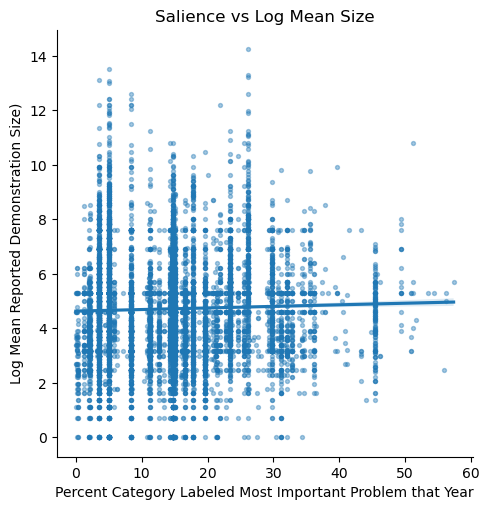

In [236]:
sns.lmplot(x = 'perc', y = target_cont,   
            data = demo_data,
            fit_reg = True, scatter_kws={'alpha': 0.4, 's': 8 })
plt.xlabel("Percent Category Labeled Most Important Problem that Year")
plt.ylabel("Log Mean Reported Demonstration Size)")
plt.title("Salience vs Log Mean Size")
plt.show()

#### Ordinary Least Squares (OLS)

In [237]:
ols_log_size_mean_by_perc = ols(formula = 'log_size_mean ~ perc', data = demo_data)
ols_log_size_mean_by_perc_fit = ols_log_size_mean_by_perc.fit()
print( ols_log_size_mean_by_perc_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.73
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           0.000616
Time:                        21:05:57   Log-Likelihood:                -29150.
No. Observations:               14832   AIC:                         5.830e+04
Df Residuals:                   14830   BIC:                         5.832e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6322      0.028    163.404      0.0

Despite having an R-squared of 0.001, the F-statistic is at 11.73—highly significant. Indeed, both the intercept and perc have very small p-values.

In other words, though the percent category labeled Most Important Problem that year does not explain nearly any of the variance in the log mean reported size of demonstrations, it is nevertheless explaining some of it.

In [238]:
ols_log_size_mean_by_perc_pop = ols(formula = 'log_size_mean ~ perc + DP05_0001PE', data = demo_data)
ols_log_size_mean_by_perc_pop_fit = ols_log_size_mean_by_perc_pop.fit()
print( ols_log_size_mean_by_perc_pop_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     24.46
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.48e-11
Time:                        21:05:57   Log-Likelihood:                -29132.
No. Observations:               14832   AIC:                         5.827e+04
Df Residuals:                   14829   BIC:                         5.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5712      0.030    152.215      

Adding in population greatly boosts the predictive power.

In [239]:
# ols_log_size_mean_by_all = ols(formula = 'log_size_mean ~ .', data = demo_data)
# ols_log_size_mean_by_all_fit = ols_log_size_mean_by_all.fit()
# print( ols_log_size_mean_by_all.summary() )

In [240]:
demo_lm = LinearRegression()  # instantiate
demo_lm.fit(X_train, y_train_cont)
print("R^2 (with the test set):", demo_lm.score(X_test, y_test_cont))
print("R^2 (with the train set):", demo_lm.score(X_train, y_train_cont))

R^2 (with the test set): -0.08407292304439218
R^2 (with the train set): 0.28886756508404077


Worse than random chance.

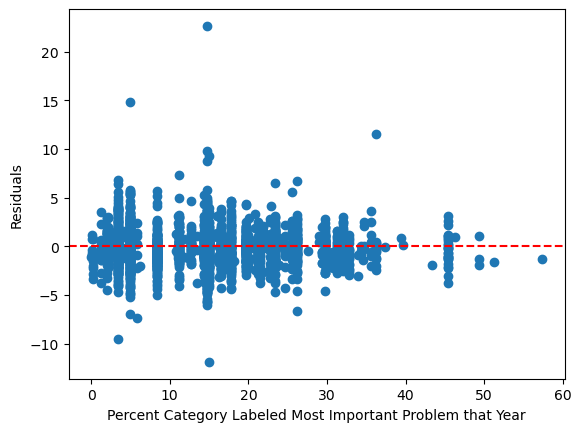

In [241]:
y_pred = demo_lm.predict(X_test)
res = y_test_cont - y_pred

plt.scatter(demo_test["perc"], res)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Percent Category Labeled Most Important Problem that Year")
plt.ylabel('Residuals')
plt.show()

Normally distributed about 0; good. However, it's notably heteroskedastic, reducing in variance as the percent increases.

#### Logistic Regression

In [242]:
demo_logit = LogisticRegression(penalty="l2", C=1, random_state=seed, max_iter=1000)
demo_logit.fit(X_train, y_train_cat)
# Cross-validation
kfold = KFold(5, random_state = seed, shuffle = True)
grid_logit = GridSearchCV(demo_logit, {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_logit.fit(X_train, y_train_cat)

print( grid_logit.best_params_ )
print( grid_logit.cv_results_[('mean_test_score')] )

demo_logit = grid_logit.best_estimator_

print('Logit model accuracy (with the test set):', demo_logit.score(X_test, y_test_cat))
print('Logit model accuracy (with the train set):', demo_logit.score(X_train, y_train_cat))

{'C': 0.01}
[0.5562579  0.55844922 0.55549937 0.55103245 0.54538559 0.54462705
 0.54235145]
Logit model accuracy (with the test set): 0.5594876980114594
Logit model accuracy (with the train set): 0.6320269700800675


### Tree

#### Regression Tree

In [243]:
demo_dtr = DecisionTreeRegressor(max_depth=3, random_state=seed)
demo_dtr.fit(X_train,y_train_cont)
demo_dtr.score(X_test,y_test_cont)

0.14935358352054573

Run cross-validation to choose the best `max_depth` and `criterion`.

In [244]:
param_grid_dtr = {'max_depth': range(3, 15)}
                 #'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')} 
# Cross-validation
grid_dtr = GridSearchCV(demo_dtr, param_grid_dtr, cv = kfold, scoring = None, n_jobs=6)
grid_dtr.fit(X_train, y_train_cont)

print( grid_dtr.best_params_ )
print( grid_dtr.cv_results_[('mean_test_score')] )
demo_dtr = grid_dtr.best_estimator_

{'max_depth': 4}
[ 0.15007136  0.16850017  0.16767062  0.16849286  0.15681838  0.13291466
  0.1078096   0.06604089  0.03893136 -0.00183611 -0.0318799  -0.0714135 ]


In [245]:
demo_dtr.score(X_test,y_test_cont)

0.16401399101027536

Tree does decently well, even on the test data.

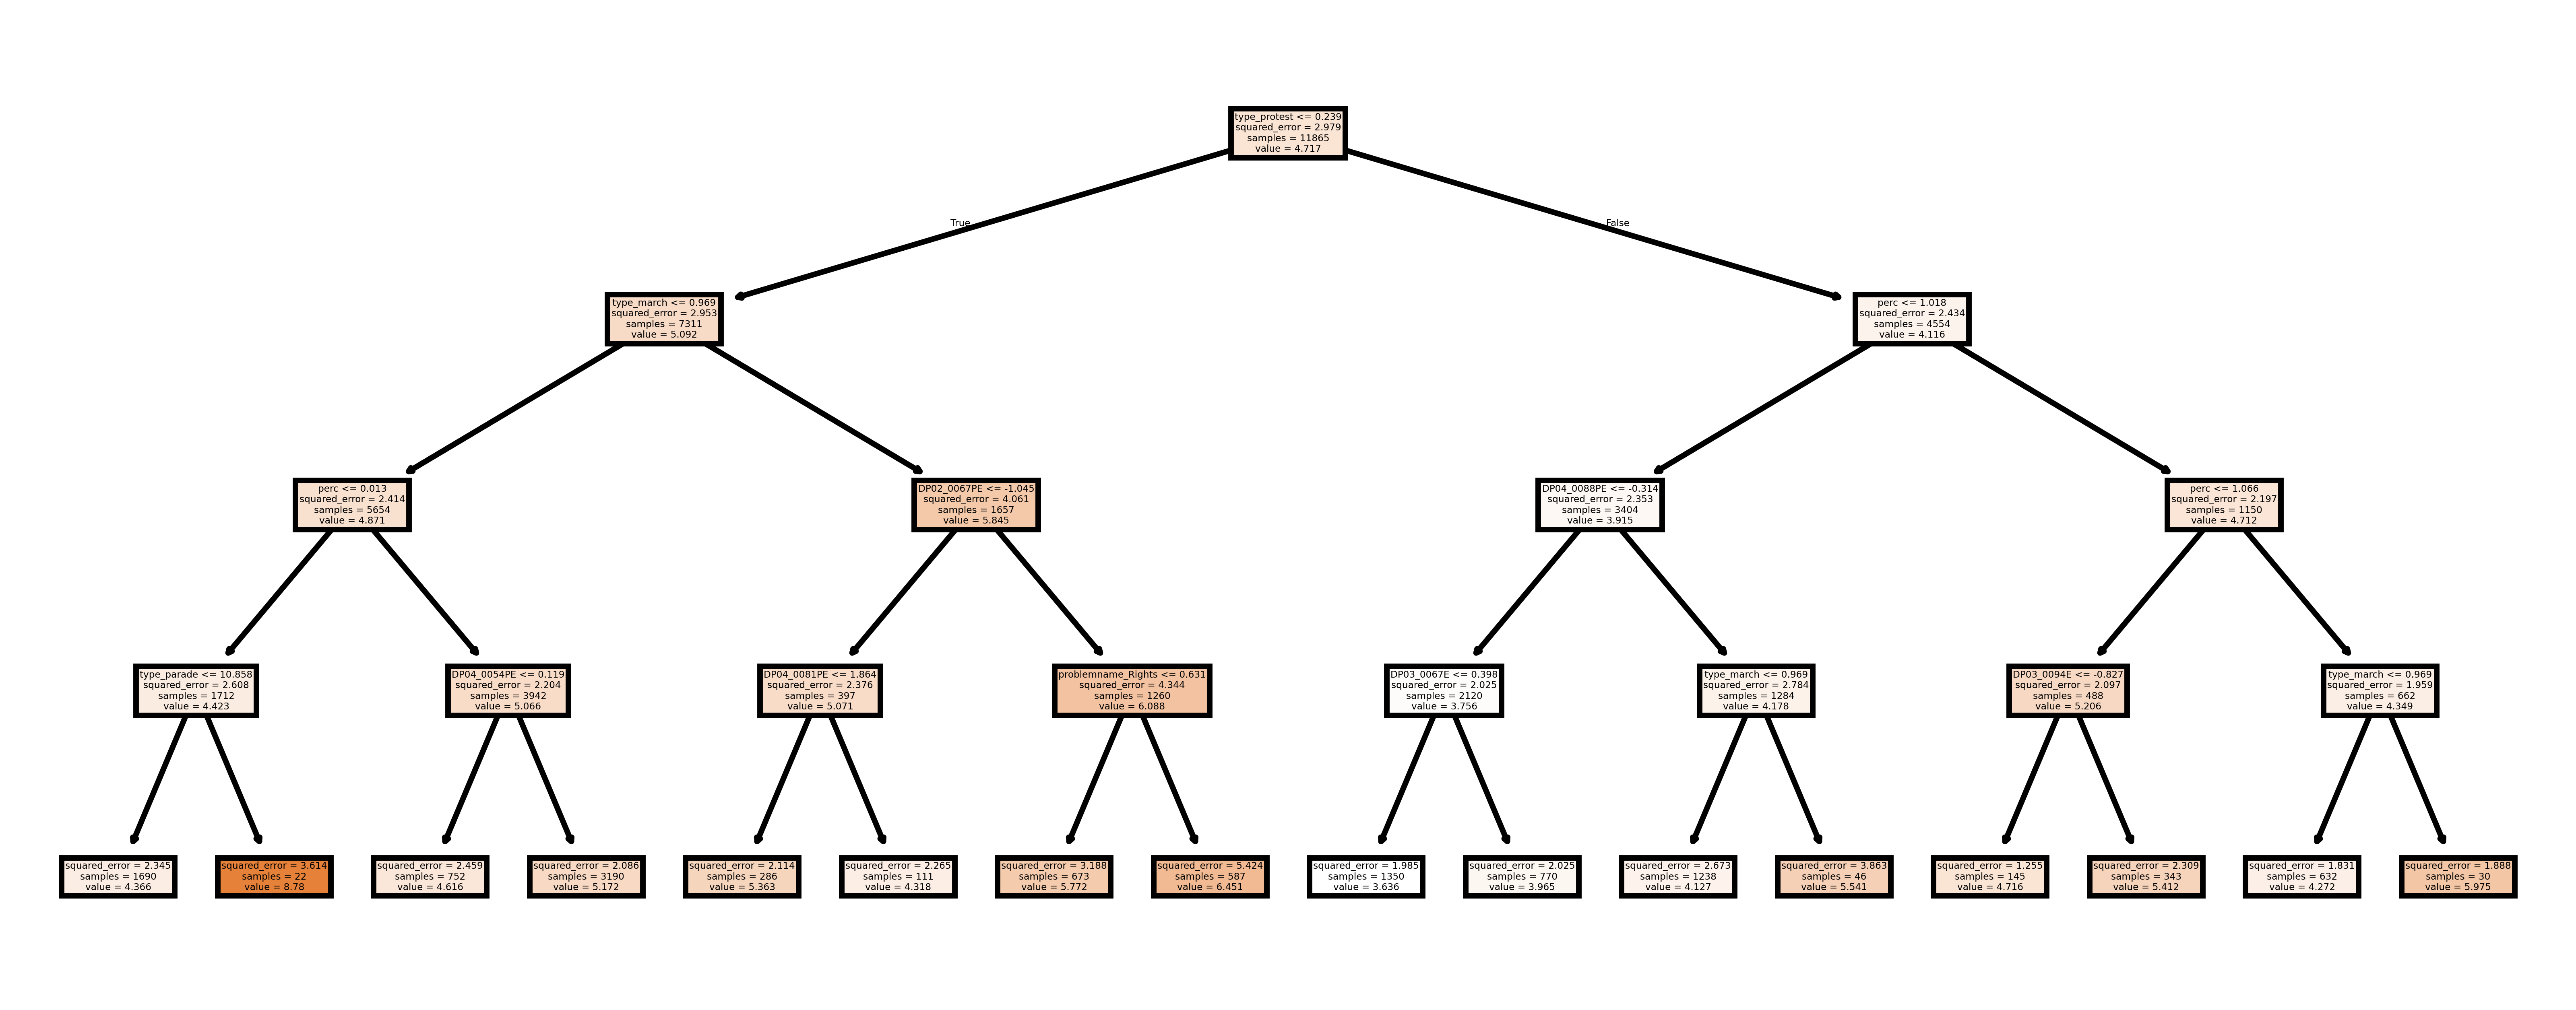

In [246]:
plt.figure(dpi=1000,figsize=(8,3))
plot_tree(demo_dtr, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`type_protest`, `type_march`, and `perc` were the three most important variables. Other important ones include `DP02_0067PE` (percent of the population 25 years old or older that has at least achieved a high school degree) and `DP03_0062E` (median household income).

#### Decision Tree

In [247]:
demo_dtc = DecisionTreeClassifier(max_depth=3, random_state=seed)
demo_dtc.fit(X_train,y_train_cat)
demo_dtc.score(X_test,y_test_cat)

0.5817323896191439

In [248]:
param_grid_dtc = {'max_depth': range(3, 15, 2),
                  "criterion":("gini","entropy","log_loss")}
# Cross-validation
grid_dtc = GridSearchCV(demo_dtc, param_grid_dtc, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_dtc.fit(X_train, y_train_cat)

print( grid_dtc.best_params_ )
print( grid_dtc.cv_results_[('mean_test_score')] )
demo_dtc = grid_dtc.best_estimator_

{'criterion': 'gini', 'max_depth': 3}
[0.56923725 0.56603456 0.56552887 0.5653603  0.56038769 0.54968394
 0.55988201 0.56822587 0.56249473 0.56375895 0.55583649 0.5507796
 0.55988201 0.56822587 0.56249473 0.56375895 0.55583649 0.5507796 ]


In [249]:
demo_dtc.score(X_test,y_test_cat)

0.5817323896191439

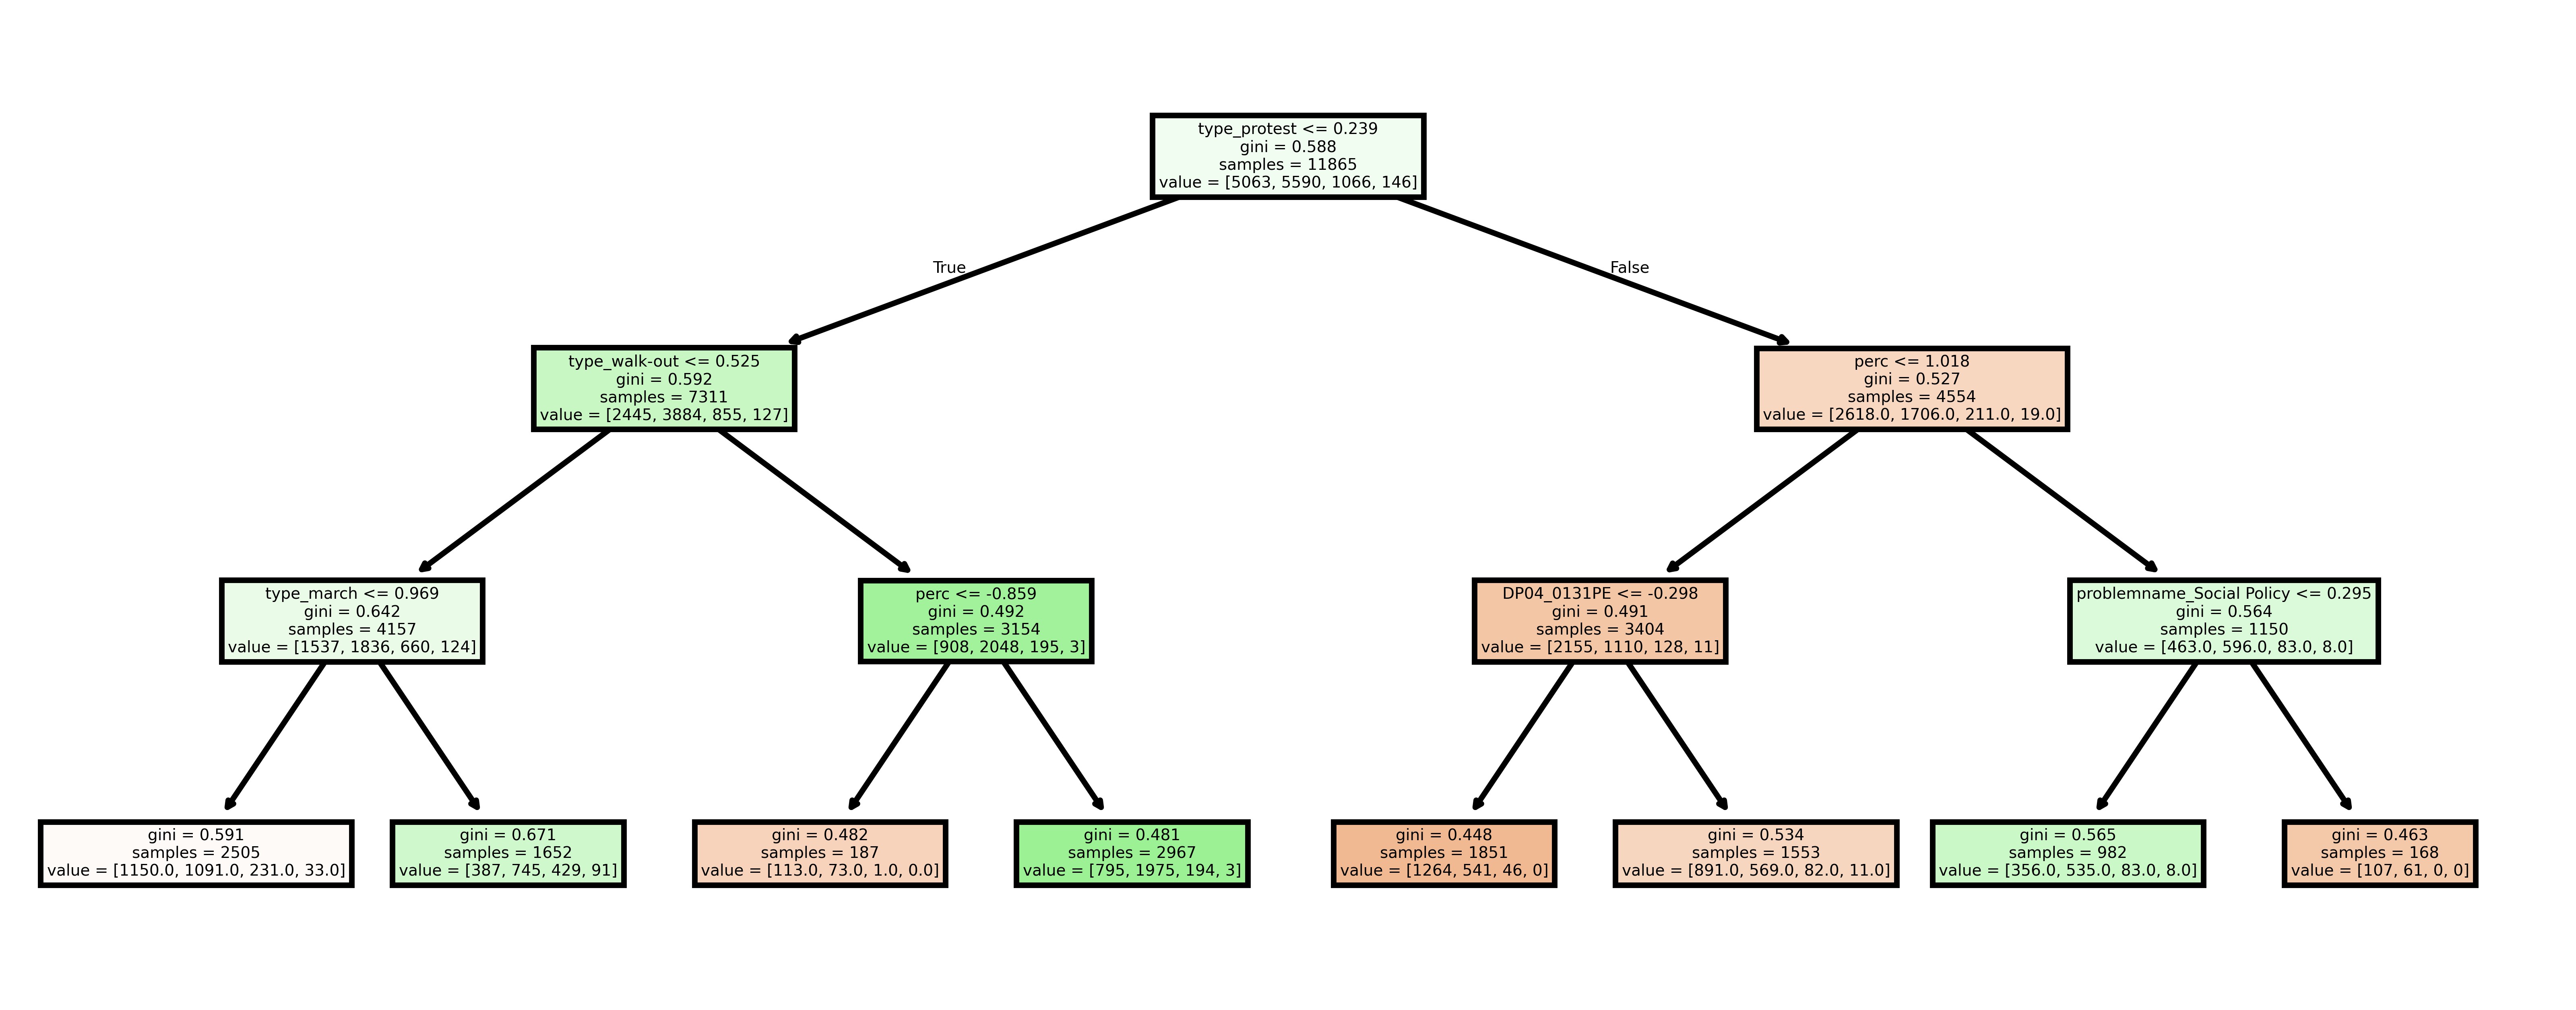

In [250]:
plt.figure(dpi=1000,figsize=(8,3))
plot_tree(demo_dtc, feature_names=np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`march`, `walk-out`, and `DP02_0067PE` (percent of the population that has at least achieved a high school degree) were the three most important variables. Other important ones include `protest`, `perc`, and `DP04_0110PE` (percent of housing units with a mortgage, excluding those whose Selected Monthly Owner Costs As a Percentage of household Income (SMOCAPI) cannot be calculated).

Interesting to note are `DP02_0123PE` (percent of the population 5 years or older that speaks a language at home other than English and that speaks English less than "very well")—higher percents have larger protests—and `DP02_0031PE` (percent of females 15 years old or older who are married)—higher percents have larger protests.

### Random Forest

#### Random Forest Regression

In [251]:
demo_rfr = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfr.fit(X_train, y_train_cont)

print("R^2 (with the test data):", demo_rfr.score(X_test, y_test_cont))

R^2 (with the test data): 0.16431732218982598


In [252]:
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11],
    'n_estimators': [5, 10, 15, 20, 25, 30]
} 
# Cross-validation
grid_rfr = GridSearchCV(demo_rfr, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfr.fit(X_train, y_train_cont)

print( grid_rfr.best_params_ )
print( grid_rfr.cv_results_[('mean_test_score')] )
demo_rfr = grid_rfr.best_estimator_

{'max_depth': 7, 'n_estimators': 30}
[0.15702777 0.16211207 0.16319623 0.16335896 0.16459848 0.16513081
 0.18587972 0.19350146 0.19377805 0.19413492 0.19553905 0.19569277
 0.18288429 0.19800477 0.20179305 0.20424539 0.2059686  0.20650677
 0.16979732 0.19286577 0.19888668 0.20199874 0.20522697 0.20618843
 0.1481966  0.17483828 0.18383984 0.18995132 0.19248608 0.19441123]


Best: max depth 7, 30 estimators

In [253]:
demo_rfr.score(X_test, y_test_cont)

0.20030126948963323

In [254]:
rfr_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfr.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfr_feature_imp = rfr_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfr_feature_imp.head(20)

,Feature,Gini Importance,LABEL
0,type_protest,0.229087,
1,type_march,0.136893,
2,perc,0.124373,
3,type_parade,0.037846,
4,problemname_Rights,0.021351,
5,problemname_Fiscal Policy,0.020349,
6,DP04_0054PE,0.013009,Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999
7,DP04_0042PE,0.009529,Percent!!BEDROOMS!!Total housing units!!3 bedrooms
8,DP02_0067PE,0.009232,Percent!!EDUCATIONAL ATTAINMENT!!Percent bachelor's degree or higher
9,problemname_Social Policy,0.009224,


New information: `DP02_0064PE` (percent of the population 25 years old or older that has graduated from high school or the equivalent) and `DP02_0061PE` (percent of the population 25 years old or older that has a 9th–12th-grade education without a high school diploma) are also important, as is local effects (a la the categorical `fips_code`). Rounding out the top 20 are `DP03_0085PE` (percent of families whose income and benefits (in 2024 inflation-adjusted dollars) equal or exceed $200,000), `DP02_0065PE

#### Random Forest Classification

In [255]:
demo_rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfc.fit(X_train, y_train_cat)

print('RFC model accuracy (with the test set):', demo_rfc.score(X_test, y_test_cat))
print('RFC model accuracy (with the train set):', demo_rfc.score(X_train, y_train_cat))

RFC model accuracy (with the test set): 0.5190428041793057
RFC model accuracy (with the train set): 0.5277707543194269


In [256]:
# Cross-validation
grid_rfc = GridSearchCV(demo_rfc, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfc.fit(X_train, y_train_cat)

print( grid_rfc.best_params_ )
print( grid_rfc.cv_results_[('mean_test_score')])
demo_rfc = grid_rfc.best_estimator_

{'max_depth': 11, 'n_estimators': 30}
[0.50459334 0.50914454 0.50939739 0.51066161 0.51453856 0.51824694
 0.5120944  0.51765697 0.52364096 0.52330383 0.5202697  0.52195533
 0.51361146 0.51512853 0.51698272 0.52085967 0.52069111 0.52330383
 0.51462284 0.51900548 0.52203961 0.52102823 0.52524231 0.52827644
 0.51597134 0.52170249 0.52389381 0.52692794 0.52743363 0.52861357]


In [257]:
demo_rfc.score(X_test, y_test_cat)

0.5294910684192787

In [258]:
rfc_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfc.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfc_feature_imp = rfc_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfc_feature_imp.head(20)

,Feature,Gini Importance,LABEL
0,perc,0.059736,
1,type_protest,0.046074,
2,type_march,0.044785,
3,type_walk-out,0.035615,
4,problemname_Public Safety,0.027609,
5,problemname_Rights,0.019932,
6,type_rally,0.017977,
7,problemname_Politics,0.017859,
8,problemname_Social Policy,0.017496,
9,problemname_Fiscal Policy,0.012512,


Here, we see entirely different demographic variables: for some reason, the percent of occupied housing units moved into in different decades continuese to be significant.

### K Nearest Neighbors

#### K Nearest Neighbors Regression

In [259]:
demo_knnr = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': range(1,31)} 
# Cross-validation
grid_knnr = GridSearchCV(demo_knnr, param_grid_knn, cv = kfold, scoring = None, n_jobs=6)
grid_knnr.fit(X_train, y_train_cont)

print( grid_knnr.best_params_ )
print( grid_knnr.cv_results_[('mean_test_score')] )
demo_knnr=grid_knnr.best_estimator_

{'n_neighbors': 26}
[-6.55317384e-01 -2.92175207e-01 -1.80898012e-01 -1.14479648e-01
 -7.70247804e-02 -5.80480868e-02 -4.02236876e-02 -2.95899324e-02
 -2.26479037e-02 -1.81200988e-02 -1.16912789e-02 -6.95693173e-03
 -3.32637583e-03 -6.54912501e-04  5.68404457e-04  5.27737720e-03
  8.64490572e-03  1.02662479e-02  1.35086199e-02  1.26292902e-02
  1.42859416e-02  1.27758885e-02  1.38895622e-02  1.61090518e-02
  1.79401929e-02  1.89022708e-02  1.85979870e-02  1.80711695e-02
  1.87499973e-02  1.85378190e-02]


In [260]:
demo_knnr.score(X_test, y_test_cont)

0.03157245561130051

KNN tried its best, but it is not the correct model to use here.

#### K Nearest Neighbors Classification

In [261]:
demo_knnc = KNeighborsClassifier()
# Cross-validation
grid_knnc = GridSearchCV(demo_knnc, param_grid_knn, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_knnc.fit(X_train, y_train_cat)

print( grid_knnc.best_params_ )
print( grid_knnc.cv_results_[('mean_test_score')] )
demo_knnc=grid_knnc.best_estimator_

{'n_neighbors': 21}
[0.47501054 0.49355247 0.49667088 0.49414244 0.49818795 0.49785082
 0.4979351  0.49894648 0.49633375 0.50257059 0.50088496 0.5002107
 0.50054783 0.49877792 0.49827223 0.49818795 0.49624947 0.50029499
 0.49919933 0.4997893  0.50316056 0.50037927 0.49827223 0.49734513
 0.49700801 0.50172777 0.49641804 0.4988622  0.4975137  0.49641804]


In [262]:
demo_knnc.score(X_test, y_test_cat)

0.5062352544657903

Barely better than chance.

## Model Evaluation

### Check performance metrics like Accuracy, Precision, F1-score, Recall.

In [ ]:
print("Logit Classification\n", classification_report( y_test_cat, demo_logit.predict(X_test) ) )
print("Decision Tree Classification\n", classification_report( y_test_cat, demo_dtc.predict(X_test) ) )
print("Random Forest Classification\n", classification_report( y_test_cat, demo_rfc.predict(X_test) ) )
print("K Nearest Neighbors Classification\n", classification_report( y_test_cat, demo_knnc.predict(X_test) ) )

Recall of the biggest demonstration sizes is more important here, as it is better to allocate resources where they are not needed than to not when they are necessary. As such, though the best logistic regression model has a lower overall accuracy than the best decision tree classifier, as it is slightly better at predicting those larger demonstration sizes, that looks to be the best model.

### Plot the One vs. Rest multiclass ROC-AUC curves for the trained classifiers

ROC-AUC can only be applied to binary classifiers. As such, a One vs. Rest strategy may be used, plotting multiple curves: one for each class, where a failure is a classification of any of the others.

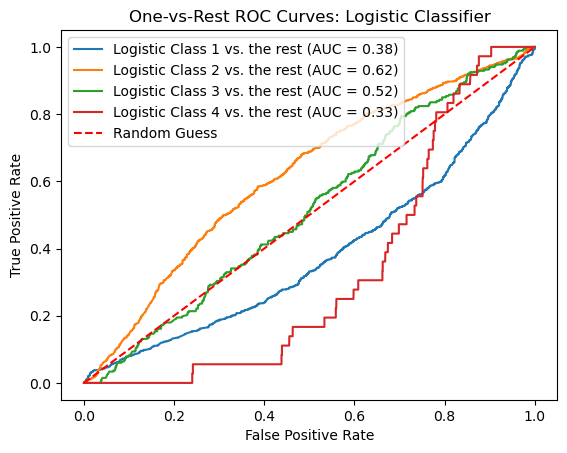

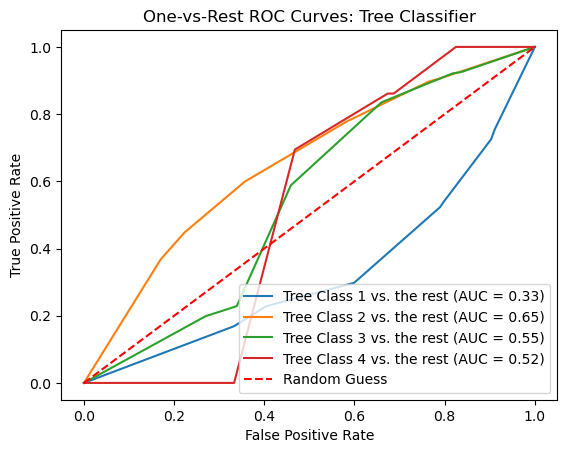

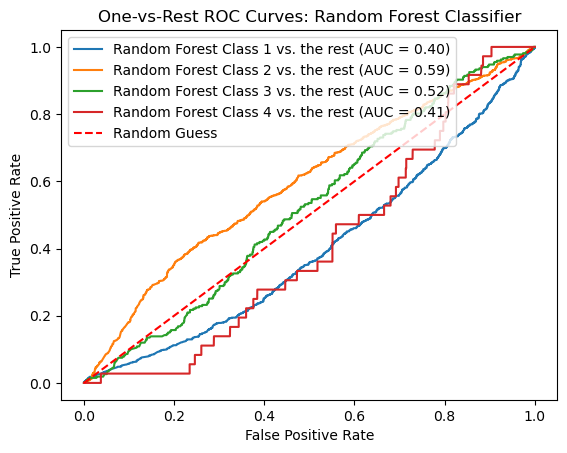

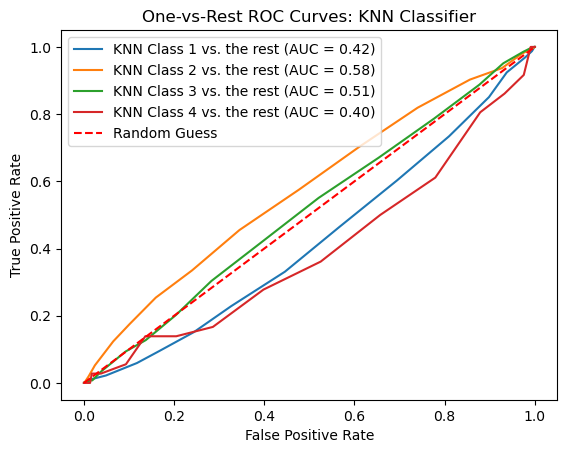

In [283]:
label_binarizer = LabelBinarizer().fit(y_train_cat) # sourced from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y_test_cat_onehot = label_binarizer.transform(y_test_cat)
# y_test_cat_onehot.shape  # (n_samples, n_classes)

class_names=y_test_cat.unique().sort_values()

def OvR_ROC_AUC(X_test, y_test_onehot, cat_model, cat_model_name, classes, class_names):
    for class_of_interest in classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        
        fpr, tpr, _ = roc_curve(y_test_onehot[:, class_id], cat_model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cat_model_name} Class {class_names[class_id]} vs. the rest (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-Rest ROC Curves: {cat_model_name} Classifier')
    plt.legend()
    plt.show()

OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_logit, cat_model_name="Logistic", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_dtc, cat_model_name="Tree", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_rfc, cat_model_name="Random Forest", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_knnc, cat_model_name="KNN", classes=label_binarizer.classes_, class_names=class_names)



# # Logit
# fpr, tpr, _ = roc_curve(y_test_cat, demo_logit.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.2f})')
# # Decision Tree
# fpr, tpr, _ = roc_curve(y_test_cat, demo_dtc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Tree (AUC = {roc_auc:.2f})')
# # Random Forest
# fpr, tpr, _ = roc_curve(y_test_cat, demo_rfc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
# # KNN
# fpr, tpr, _ = roc_curve(y_test_cat, demo_knnc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Two Models')
# plt.legend()
# plt.show()

Judging by the ROC-AUC curves, the best decision tree would appear to be the best model.

## Dimensionality Reduction

### Primary Component Analysis

In [264]:
# PCA Computations
# X_avg = np.mean(X_train, axis = 0)
# B = X_train - np.tile(X_avg, (len(X_train), 1))

# U, S, VT = np.linalg.svd(B / np.sqrt(len(X_train)), full_matrices=True)
# V = VT.T

# #t = np.arange(0, 1, 0.1)
# # plt.plot(t, V[1, 0]/V[0, 0] * t)
# # plt.plot(t, V[1, 1]/V[0, 1] * t)
# plt.quiver([X_avg[0], X_avg[0]], [X_avg[1],X_avg[1]], V[0,:], V[1,:], scale=8, zorder=2, color=['b', 'r'])
# plt.show()

# theta = 2 * np.pi * np.arange(0, 1, 0.01)
# Xstd = np.array([np.cos(theta), np.sin(theta)]).T @ np.diag(S) @ VT

# plt.plot(Xavg[0] +     Xstd[:, 0], Xavg[1] +     Xstd[:,1])
# plt.plot(Xavg[0] + 2 * Xstd[:, 0], Xavg[1] + 2 * Xstd[:,1])
# plt.plot(Xavg[0] + 3 * Xstd[:, 0], Xavg[1] + 3 * Xstd[:,1])
# plt.show()

In [265]:
demo_pca = PCA(n_components=0.95)  # Retain 95% of variance
demo_pca.fit(X_train)

# Transform the data using the new components
data_pca = demo_pca.transform(X_train)

In [266]:
pca_lm = LinearRegression()
pca_lm.fit(X_train,y_train_cont)

print("R^2 (with the test set):", pca_lm.score(X_test, y_test_cont))
print("R^2 (with the train set):", pca_lm.score(X_train, y_train_cont))

R^2 (with the test set): -0.08407292304439218
R^2 (with the train set): 0.28886756508404077
